#### Libraries

In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import accuracy_score


----

#### Funcitons For Model

In [33]:
def fit_model(cnn_model, train_data, train_labels , test_data, test_labels, es, checkpoint_cb):
    history = cnn_model.fit(train_data, 
        train_labels, 
        epochs=10,
        validation_data=(test_data, test_labels),
        callbacks=[es, checkpoint_cb])
    return history

def model_evaluation(model, test_data, test_labels):
    test_loss, test_acc = model.evaluate(test_data, test_labels,verbose=2)
    print(f'Test Accuracy Score {test_acc}:\n Test Loss {test_loss}')
    return test_loss, test_acc

def save_model(cnn_model):
    save_dir = "saved_model/my_model"
    os.makedirs(save_dir, exist_ok=True)
    cnn_model.save("saved_model/my_model/model.keras")

def load_cnn_model():
    model = tf.keras.models.load_model('saved_model/my_model/model.keras')
    return model

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))  # İstenen boyuta yeniden boyutlandır
    image = image.astype(np.float32)  # Veri türünü float32'ye çevir
    image = image / 255.0  # Normalizasyon (0 ile 1 arasına ölçekleme)
    return image

-----

#### Functions for Prediction

In [21]:
def make_single_prediction(model, image):
    
    predictions = model.predict(np.expand_dims(image, axis=0))
    predicted_class_index = np.argmax(predictions, axis=1)
    prediction = ["Male" if predicted_class_index > 0.55 else "Female"]

    print(f"Models Prediction is {prediction}")
    
    return predicted_class_index

def make_prediction_with_time(model, test_data, test_labels):
    import time
    start_time = time.time()
    predictions = model.predict(test_data)
    end_time = time.time()
    inference_time = end_time - start_time

    rounded_predictions = np.argmax(predictions, axis=1)
    true_labels = test_labels
    accuracy = accuracy_score(true_labels, rounded_predictions)
    print(f"Prediction Accuracy: {accuracy}")

    print(f"Prediction Time is: {inference_time} seconds")

    return predictions, inference_time

---

#### Funcitons For Getting Images

In [6]:
def scale_images(images):
    scaled_images = images / 255.0
    return scaled_images

def get_dataset_for_train_test(path):
    images = []
    labels = []
    class_folders = os.listdir(path)
    print(class_folders)
    for class_folder in class_folders:
        class_path = os.path.join(path, class_folder)
        image_files = os.listdir(class_path)

        for img_file in image_files:

            image_path = os.path.join(class_path, img_file)
            label = 1 if class_folder == "Male" else 0
            image = cv2.imread(image_path)
            image = cv2.resize(image, (100,100)) 

            images.append(image)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    images = images.astype(np.float32)

    # Ölçekleme işlemi
    scaled_images = scale_images(images)

    return scaled_images, labels

----

#### Funcitons for Visualization

In [7]:
def plot_labels(train_labels, test_labels):
    ##### Plotting by gender
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    male_counter = sum(1 for label in train_labels if label == 1)
    female_counter = sum(1 for label in train_labels if label == 0)
    sns.barplot(x=["Male", "Female"], y=[male_counter, female_counter])
    plt.title("Male vs Female Counts in Train Data")
    plt.legend(labels=[f"Male (Count: {male_counter})", f"Female (Count: {female_counter})"])
    plt.xlabel("Gender")
    plt.ylabel("Count")

    ##### Plotting by gender
    plt.subplot(1, 2, 2)
    male_counter = sum(1 for label in test_labels if label == 1)
    female_counter = sum(1 for label in test_labels if label == 0)
    sns.barplot(x=["Male", "Female"], y=[male_counter, female_counter])
    plt.title("Male vs Female Counts in Test Data")
    plt.legend(labels=[f"Male (Count: {male_counter})", f"Female (Count: {female_counter})"])
    plt.xlabel("Gender")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

def visualize_history(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

---

#### CNN Model

In [36]:
@tf.keras.saving.register_keras_serializable()
class MyCNNModel(tf.keras.Model):
    def __init__(self):
        super(MyCNNModel, self).__init__()

        # Layers
        self.conv1 = tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv2 = tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.dense2 = tf.keras.layers.Dense(2, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batchnorm1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)

        return x        
   


#### Functions for Early Stopping and Chechpoint Callback

In [9]:
def chechpoint_callback(checkpoint_path):
    checkpoint_path = "training_1/my_checkpoints"
    os.makedirs(checkpoint_path, exist_ok=True) 
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_path, "weights.h5"),
    # Modelin sadece ağırlıklarını kaydedelim
    save_weights_only=True)
    return checkpoint_cb


In [23]:
def set_early_stopping():
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    return es

#### Get Data

In [24]:
train_data, train_labels = get_dataset_for_train_test("Face_Gender/Train/Train/")
test_data, test_labels = get_dataset_for_train_test("Face_Gender/Test/Test/")

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))


# Shuffle
BUFFER_SIZE = len(train_data)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

test_dataset = test_dataset.shuffle(BUFFER_SIZE)

['Female', 'Male']
['Female', 'Male']


### Plot Labels

c:\Users\frknq\ImageProcessing\Code\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\frknq\ImageProcessing\Code\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\frknq\ImageProcessing\Code\.conda\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\frknq\ImageProcessing\Code\.conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

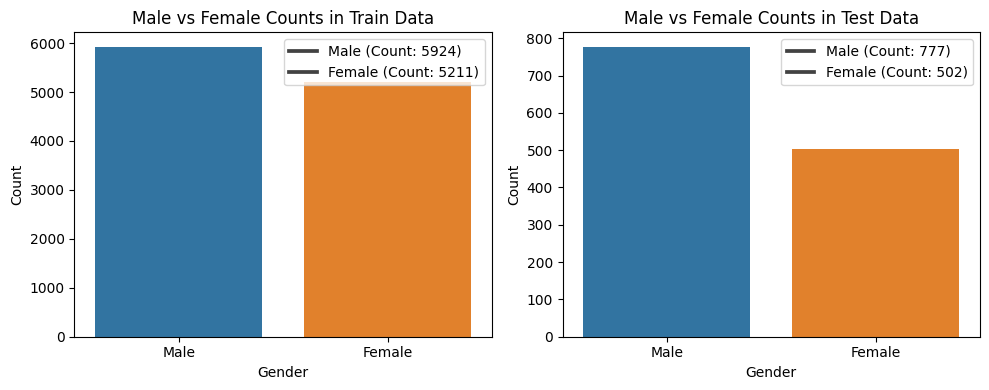

In [12]:
plot_labels(train_labels, test_labels)

#### Set Chechpoint Callback and Early Stopping

In [26]:
checkpoint_path = "training/my_checkpoints"
checkpoint_cb = chechpoint_callback(checkpoint_path)

es = set_early_stopping()

#### Training the CNN Model

In [27]:
cnn_model = MyCNNModel()

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = fit_model(cnn_model, train_data, train_labels , test_data, test_labels, es, checkpoint_cb)

Epoch 1/10
348/348 [==============================] - 79s 223ms/step - loss: 0.5194 - sparse_categorical_accuracy: 0.7663 - val_loss: 0.7580 - val_sparse_categorical_accuracy: 0.5747
Epoch 2/10
348/348 [==============================] - 78s 223ms/step - loss: 0.3164 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.3035 - val_sparse_categorical_accuracy: 0.8733
Epoch 3/10
348/348 [==============================] - 77s 223ms/step - loss: 0.2357 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.2730 - val_sparse_categorical_accuracy: 0.8882
Epoch 4/10
348/348 [==============================] - 81s 232ms/step - loss: 0.1927 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.2706 - val_sparse_categorical_accuracy: 0.8898
Epoch 5/10
348/348 [==============================] - 81s 233ms/step - loss: 0.1546 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.2985 - val_sparse_categorical_accuracy: 0.8890
Epoch 6/10
348/348 [==============================] - 80s 228ms/step - loss: 0.1270 -

#### Visualize the Accuracy And Loss Plot for Each Epoch

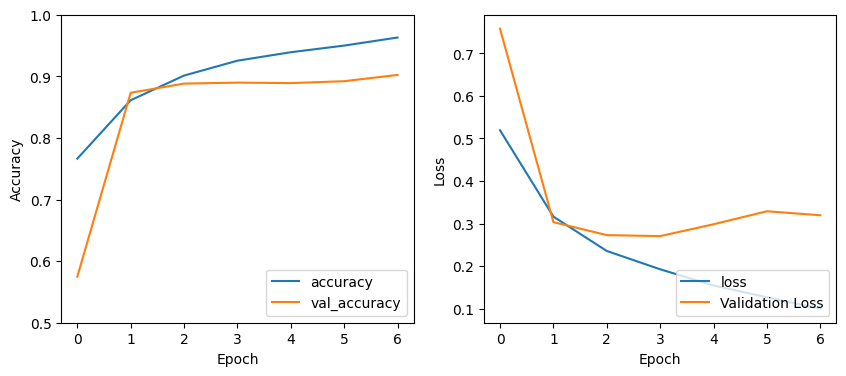

In [28]:
visualize_history(history)

#### Testing with Evaluate

In [29]:
_ , _ = model_evaluation(cnn_model, test_data, test_labels)

40/40 - 2s - loss: 0.3197 - sparse_categorical_accuracy: 0.9023 - 2s/epoch - 54ms/step
Test Accuracy Score 0.9022673964500427:
 Test Loss 0.31966882944107056


In [30]:
_ , _= make_prediction_with_time(cnn_model, test_data, test_labels)

40/40 [==============================] - 2s 47ms/step
Prediction Accuracy: 0.9022673964034402
Prediction Time is: 2.1803579330444336 seconds


In [31]:
save_model(cnn_model)

#### Create and Load Model

In [ ]:
cnn_model = MyCNNModel()
cnn_model = load_cnn_model()

In [ ]:
img_path = None

if img_path != None:
    image = load_image(img_path)
    make_single_prediction(cnn_model, image)
    plt.imshow(image)
    plt.show()